In [1]:
# Libraries
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
plt.style.use("seaborn-v0_8-whitegrid")
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 600

# Constants
random.seed(0)
np.random.default_rng()
tf = 60
dt = 0.001
N = round(tf/dt)
t = np.arange(0, tf, dt)

c0 = [0, 0]

def x_curve(t, k1, k2, k3, k4, xi):
    """
    Generates the analytical x curve for a given set of parameters.
    Args:
    t:  Time (array)
    k1: k1 constant (float)
    k2: k2 constant (float)
    k3: k3 constant (float)
    k4: k4 constant (float)
    xi: xi constant (float)
        
    Returns:
    x : X curve array
    """

    Ac = 1
    eta = Ac
    
    B = k1 + k4
    C = k1*k4 + k2*k3
    Q = k4 - k2*xi
    
    x_raya = Q/C * Ac
    eig_1 = -(-B + np.sqrt(B**2 - 4*C))/2
    eig_2 = -(-B - np.sqrt(B**2 - 4*C))/2
    C1 = (eta - eig_2*x_raya)/(eig_2-eig_1)
    C2 = (eta - eig_1*x_raya)/(eig_2-eig_1)
    return C1*np.exp(-eig_1*t) - C2*np.exp(-eig_2*t) + x_raya

In [2]:
def get_params_NFBL(initial_parameters, num_params):
    """Get the parameters for the NFBL model.
    Args:
        initial_parameters (array): list of initial parameters for NFBL
        num_params (float): number of parameters to generate
    
    Returns:
    k1: float
    k2_vals: array of floats
    k3_vals: array of floats
    k4: float
    """
    k1 = initial_parameters[0]
    k2 = initial_parameters[1]
    k3 = initial_parameters[2]
    k4 = initial_parameters[3]
    
    C = k1*k4 + k2*k3
    k2_vals = np.random.uniform(0, 3, num_params)
    k3_vals = (C - k1*k4)/k2_vals
    
    if not (all(i >= 0 for i in k2_vals) and all(i >= 0 for i in k3_vals)):
        print(initial_parameters)
        raise ValueError("All generated values must be non-negative.")
    
    return k1, k2_vals, k3_vals, k4

def get_params_IFFL(initial_parameters, num_params):
    """Get the parameters for the IFFL model.
    Args:
        initial_parameters (array): list of initial parameters for NFBL
        num_params (float): number of parameters to generate
    
    Returns:
    K1: float
    K2_vals: array of floats
    K3: float
    K4: float
    xi_vals: array of floats
    """
    
    k1 = initial_parameters[0]
    k2 = initial_parameters[1]
    k3 = initial_parameters[2]
    k4 = initial_parameters[3]
    
    # Since the initial params were constructed for NFBL
    # See curves.ipynb
    B = k1 + k4
    C = k1*k4 + k2*k3
    Q = k4
    
    if B**2 - 4*C < 0:
        print(initial_parameters)
        raise ValueError("Invalid parameters for square root in calculation of K4")
    
    K4 = (-B + np.sqrt(B**2 - 4*C)) / (-2)
    K1 = B - K4
    K3 = 0

    K2_vals = np.random.uniform(0, 3, num_params)
    xi_vals = (K4-Q)/K2_vals
    
    if K4 < 0 or K1 < 0:
        print(initial_parameters)
        raise ValueError("Invalid parameters for K1 or K4")
    
    if not (all(i >= 0 for i in K2_vals) and all(i >= 0 for i in xi_vals)):
        print(initial_parameters)
        raise ValueError("All generated values must be non-negative.")
    
    return K1, K2_vals, K3, K4, xi_vals

initial_nfbl_parameters = np.array([[1, 2, 0.05, 0.05, 1, 0], [2, 2, 0.05, 0.05, 1, 0], [2, 2, 0.1, 0.05, 1, 0], [1, 1, 0.1, 0.05, 1, 0], 
                                    [0.5, 0.5, 0.1, 0.05, 1, 0], [1, 1, 0.1, 0.1, 1, 0], [1, 2, 0.1, 0.05, 1, 0], [1, 1.25, 0.1, 0.1, 1, 0], 
                                    [3, 1, 0.1, 0.05, 1, 0], [0.75, 1.15, 0.05, 0.1, 1, 0], [1, 2.25, 0.05, 0.1, 1, 0], [1, 0.5, 0.2, 0.1, 1, 0], 
                                    [0.75, 0.2, 0.5, 0.1, 1, 0], [1.25, 0.25, 0.25, 0.15, 1, 0], [0.8, 3, 0.01, 0.05, 1, 0], [0.65, 1, 0.05, 0.1, 1, 0],
                                    [2, 1, 0.1, 0.1, 1, 0], [0.5, 2, 0.01, 0.01, 1, 0], [0.3, 2, 0.01, 0.01, 1, 0], [0.5, 1, 0.05, 0.01, 1, 0],
                                    [0.55, 1.25, 0.05, 0.01, 1, 0], [0.75, 2, 0.05, 0.01, 1, 0], [0.35, 1.5, 0.01, 0.05, 1, 0], [0.25, 0.35, 0.025, 0.05, 1, 0],
                                    [0.3875, 0.55, 0.03, 0.05, 1, 0]])

# NFBL

In [3]:
total_curves = 50000
num_curves = int(total_curves/2)
different_curves = 25 # len(initial_nfbl_parameters)
num_params = int(num_curves/different_curves)

Ac = 1
xi = 0

t = np.arange(0, tf, dt)
t_shape = np.shape(t)[0]

x = np.empty([num_curves, t_shape])
y = np.empty([num_curves, t_shape])

for i in range(different_curves):
    k1, k2_vals, k3_vals, k4 = get_params_NFBL(initial_nfbl_parameters[i], num_params)
    for j in range(num_params):
        x[i*num_params+j] = x_curve(t, k1, k2_vals[j], k3_vals[j], k4, xi)

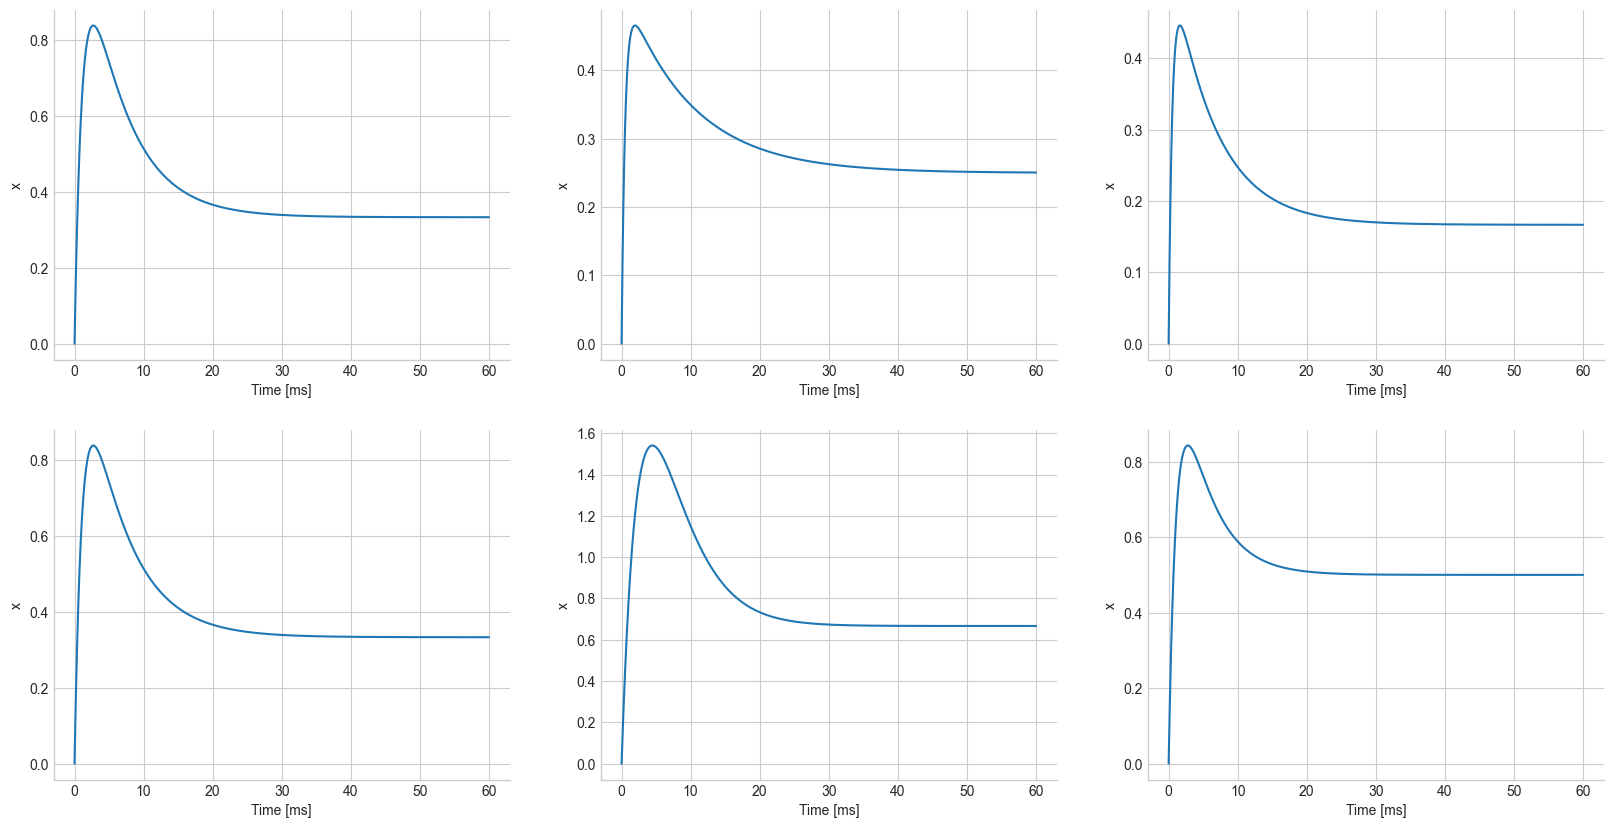

In [4]:
# Plot X
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i in range(6):
    ax[i//3, i%3].plot(t, x[i*1000])
    ax[i//3, i%3].set_xlabel('Time [ms]')
    ax[i//3, i%3].set_ylabel('x')

In [5]:
data = np.empty([num_curves*2, tf])

t_correction = int(1/dt)
indices = np.arange(tf) * t_correction

for i in range(num_curves):
    data[i] = x[i][indices]

# IFFL

In [6]:
x = np.empty([num_curves, t_shape])
y = np.empty([num_curves, t_shape])

for i in range(different_curves):
    K1, K2_vals, K3, K4, xi_vals = get_params_IFFL(initial_nfbl_parameters[i], num_params)
    for j in range(num_params):
        x[i*num_params+j] = x_curve(t, K1, K2_vals[j], K3, K4, xi_vals[j])

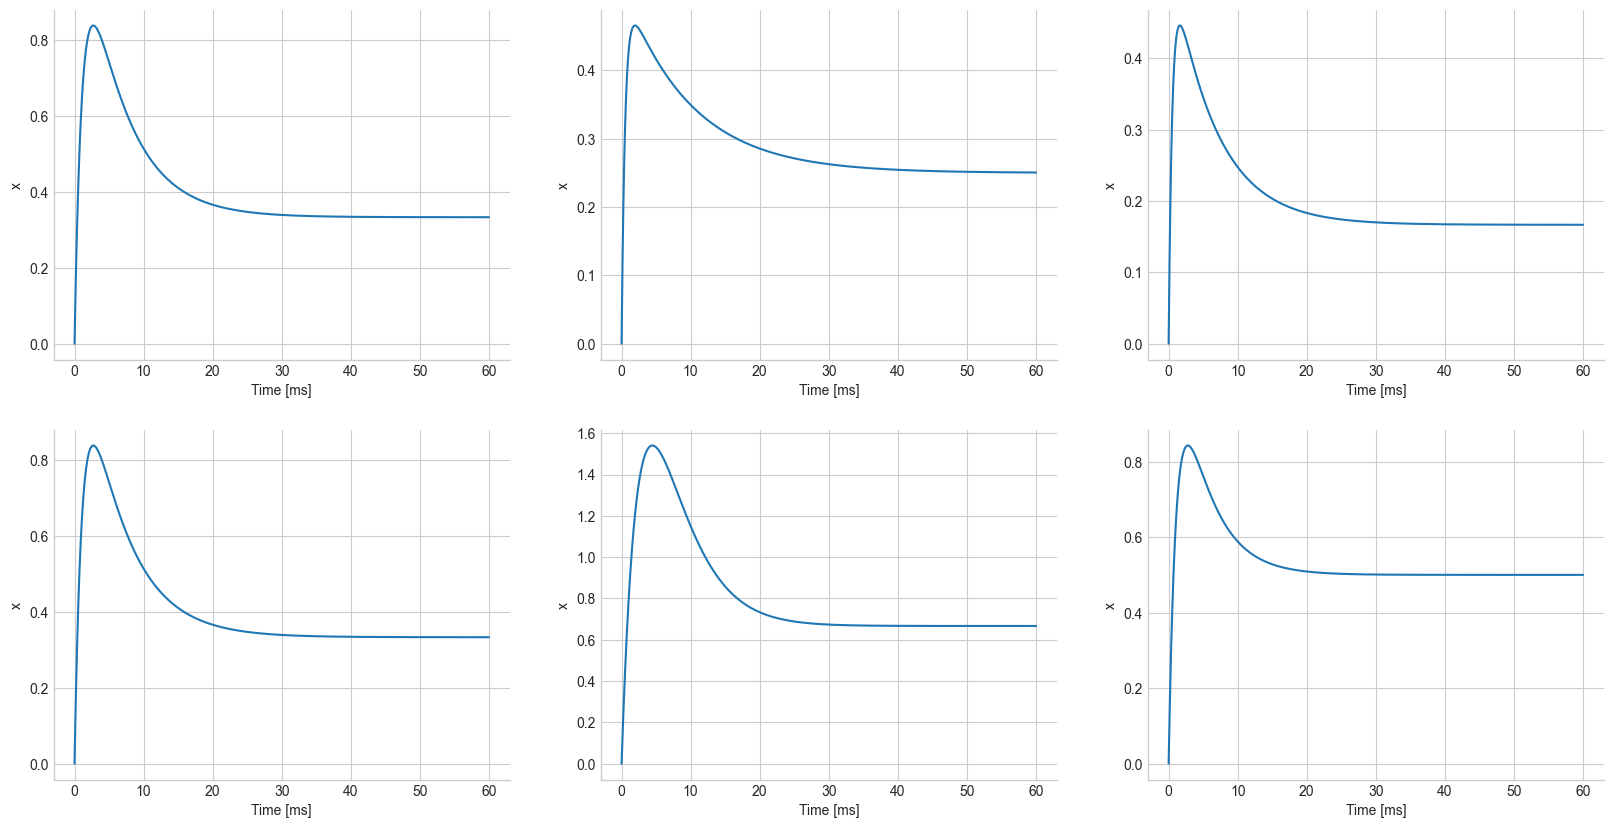

In [7]:
# Plot X
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i in range(6):
    ax[i//3, i%3].plot(t, x[i*1000])
    ax[i//3, i%3].set_xlabel('Time [ms]')
    ax[i//3, i%3].set_ylabel('x')

In [8]:
for i in range(num_curves):
    data[num_curves+i] = x[i][indices]

In [9]:
# Create the labels array
# 1 NFBL, 0 IFFL
labels = np.empty(total_curves)
labels[:num_curves] = 1
labels[num_curves:] = 0

In [10]:
# Save the data
np.savetxt("data_analytical_different_curves.csv", data, delimiter=",")
np.savetxt("labels.csv", labels, delimiter=",")